#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
from tensorflow import keras
import tensorflow as tf
from model import mobileHART_XS

import warnings
warnings.filterwarnings("ignore")

2025-05-07 15:09:57.032276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 15:09:57.041458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 15:09:57.044238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 15:09:57.051664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 15:09:57.529680: W tensorflow/compiler/tf2

# Configure GPU Memory Growth

In [2]:
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU detected and memory growth enabled on {len(physical_devices)} devices")
    else:
        print("No GPU detected, running on CPU")
except Exception as e:
    print(f"Error configuring GPU: {e}")
    print("Continuing with default configuration")

GPU detected and memory growth enabled on 2 devices


I0000 00:00:1746644998.185422  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.189843  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.211647  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.215543  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Load and Explore Data

In [3]:
columns = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
           'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)',
           'Subject_ID', 'Activity_Label']

df = pd.read_csv("SMOTE_Scaled_Combined_Active_Gyro_Accel_Cleaned_V2.csv", usecols=columns)

print("Data summary:")
print(df.head())
print("\nActivity distribution:")
print(df['Activity_Label'].value_counts())
print("\nSubject distribution:")
print(df['Subject_ID'].value_counts())

Data summary:
   Accel X (g)  Accel Y (g)  Accel Z (g)  Gyro X (°/s)  Gyro Y (°/s)  \
0     -5.98311     1.247379     8.365341      0.321315     -0.024435   
1     -5.98311     1.247379     8.365341      0.321315     -0.024435   
2     -5.98311     1.247379     8.365341      0.321315     -0.024435   
3     -5.98311     1.247379     8.365341      0.321315     -0.024435   
4     -5.98311     1.247379     8.365341      0.321315     -0.024435   

   Gyro Z (°/s)  Subject_ID Activity_Label  
0     -0.131947           1   Chair Squats  
1     -0.131947           1   Chair Squats  
2     -0.131947           1   Chair Squats  
3     -0.131947           1   Chair Squats  
4     -0.131947           1   Chair Squats  

Activity distribution:
Activity_Label
Chair Squats                   36556
Light Stationary Cycling       36556
Marching in Place              36556
Seated Boxing Hooks            36556
Seated Leg Extensions          36556
Seated Medicine Ball Twists    36556
Seated Side Bends     

# Data Normalization per Subject

In [4]:
subjects = df['Subject_ID'].unique()
normalized_dfs = []

for subject in subjects:
    subject_df = df[df['Subject_ID'] == subject].copy()
    sensor_cols = columns[:6]
    
    original_means = subject_df[sensor_cols].mean()
    original_stds = subject_df[sensor_cols].std()
    
    scaler = RobustScaler()
    subject_df[sensor_cols] = scaler.fit_transform(subject_df[sensor_cols])
    
    mask = (((subject_df[sensor_cols] >= (original_means - 2 * original_stds)) & 
             (subject_df[sensor_cols] <= (original_means + 2 * original_stds)))
            .all(axis=1))
    
    subject_df_filtered = subject_df[mask].dropna()
    
    print(f"Subject {subject}: Original rows: {len(subject_df)}, After filtering: {len(subject_df_filtered)}, " 
          f"Removed: {len(subject_df) - len(subject_df_filtered)} ({(len(subject_df) - len(subject_df_filtered))/len(subject_df)*100:.2f}%)")
    
    normalized_dfs.append(subject_df_filtered)

df = pd.concat(normalized_dfs)
print(f"\nTotal rows after filtering: {len(df)}")

Subject 1: Original rows: 62223, After filtering: 23096, Removed: 39127 (62.88%)
Subject 2: Original rows: 62456, After filtering: 41248, Removed: 21208 (33.96%)
Subject 3: Original rows: 60855, After filtering: 22216, Removed: 38639 (63.49%)
Subject 4: Original rows: 61161, After filtering: 35893, Removed: 25268 (41.31%)
Subject 5: Original rows: 51243, After filtering: 37683, Removed: 13560 (26.46%)
Subject 6: Original rows: 67622, After filtering: 47906, Removed: 19716 (29.16%)

Total rows after filtering: 208042


# Label Encoding

In [5]:
LE = LabelEncoder()
df['Activity_Label'] = LE.fit_transform(df['Activity_Label'])
activity_names = LE.classes_
print("\nActivity mapping:")
for i, activity in enumerate(activity_names):
    print(f"{i}: {activity}")


Activity mapping:
0: Chair Squats
1: Light Stationary Cycling
2: Marching in Place
3: Seated Boxing Hooks
4: Seated Leg Extensions
5: Seated Medicine Ball Twists
6: Seated Side Bends
7: Side-Stepping
8: Standing Heel-to-Toe Walk
9: Wall Push-ups


#  Define Windowing Functions

In [6]:
def create_overlapping_windows(data, window_size, step_size, features):
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        segment = data[start:start + window_size, :features]
        segments.append(segment)
    return np.array(segments)

def assign_labels_to_windows(labels, window_size, step_size):
    window_labels = []
    for start in range(0, len(labels) - window_size + 1, step_size):
        window_label = np.bincount(labels[start:start + window_size]).argmax()
        window_labels.append(window_label)
    return np.array(window_labels)

# Define Data Augmentation Function

In [7]:
def augment_data(X, y, num_augmented=0.3):
    augmented_X = []
    augmented_y = []
    
    num_to_augment = int(len(X) * num_augmented)
    num_to_augment = min(num_to_augment, len(X))
    
    if num_to_augment > 0:
        indices = np.random.choice(len(X), num_to_augment, replace=False)
        
        for idx in indices:
            noise_scale = 0.05
            noisy_sample = X[idx] + np.random.normal(0, noise_scale, X[idx].shape)
            augmented_X.append(noisy_sample)
            augmented_y.append(y[idx])
            
            if X[idx].shape[0] > 5:
                shift = np.random.randint(1, 5)
                shifted = np.roll(X[idx], shift, axis=0)
                augmented_X.append(shifted)
                augmented_y.append(y[idx])
    
    if augmented_X:
        return np.vstack([X, np.array(augmented_X)]), np.concatenate([y, np.array(augmented_y)])
    return X, y

# Create Data Windows and Split Data

In [8]:
window_size = 128
step_size = 64
num_features = 6

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

subject_5_valid_activities = set([
    'Marching in Place',
    'Wall Push-ups',
    'Seated Boxing Hooks',
    'Standing Heel-to-Toe Walk'
])
subject_5_valid_activities_encoded = set(LE.transform(list(subject_5_valid_activities)))

print("Starting window creation...")

for subject_id in df['Subject_ID'].unique():
    subject_df = df[df['Subject_ID'] == subject_id]
    
    for activity_label in subject_df['Activity_Label'].unique():
        if subject_id == 5 and activity_label not in subject_5_valid_activities_encoded:
            continue
        
        activity_df = subject_df[subject_df['Activity_Label'] == activity_label]
        
        features = activity_df.iloc[:, :6].values
        labels = activity_df['Activity_Label'].values
        
        if len(features) < window_size:
            print(f"Skipping Subject {subject_id}, Activity {LE.inverse_transform([activity_label])[0]} - Not enough data points ({len(features)})")
            continue
        
        windows = create_overlapping_windows(features, window_size, step_size, num_features)
        window_labels = assign_labels_to_windows(labels, window_size, step_size)
        
        if len(windows) == 0:
            print(f"No windows created for Subject {subject_id}, Activity {LE.inverse_transform([activity_label])[0]}")
            continue
            
        print(f"Subject {subject_id}, Activity {LE.inverse_transform([activity_label])[0]}, Windows Shape: {windows.shape}, Labels Shape: {window_labels.shape}")
        
        if len(windows.shape) != 3 or windows.shape[1] != window_size or windows.shape[2] != num_features:
            print(f"Unexpected window shape for Subject {subject_id}, Activity {LE.inverse_transform([activity_label])[0]}: {windows.shape}")
            continue
            
        train_idx = int(len(windows) * 0.7)
        val_idx = int(len(windows) * 0.85)
        
        if train_idx > 0:
            X_train_list.append(windows[:train_idx])
            y_train_list.append(window_labels[:train_idx])
        
        if val_idx > train_idx:
            X_val_list.append(windows[train_idx:val_idx])
            y_val_list.append(window_labels[train_idx:val_idx])
        
        if len(windows) > val_idx:
            X_test_list.append(windows[val_idx:])
            y_test_list.append(window_labels[val_idx:])

if not X_train_list or not y_train_list or not X_val_list or not y_val_list or not X_test_list or not y_test_list:
    raise ValueError("One or more data lists are empty! Cannot create training sets.")

for i, x in enumerate(X_train_list):
    print(f"X_train_list[{i}] shape: {x.shape}")

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)

X_train, y_train = augment_data(X_train, y_train, num_augmented=0.3)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Starting window creation...
Subject 1, Activity Chair Squats, Windows Shape: (39, 128, 6), Labels Shape: (39,)
Subject 1, Activity Light Stationary Cycling, Windows Shape: (36, 128, 6), Labels Shape: (36,)
Subject 1, Activity Marching in Place, Windows Shape: (55, 128, 6), Labels Shape: (55,)
Skipping Subject 1, Activity Seated Boxing Hooks - Not enough data points (6)
Subject 1, Activity Seated Leg Extensions, Windows Shape: (86, 128, 6), Labels Shape: (86,)
Subject 1, Activity Seated Medicine Ball Twists, Windows Shape: (26, 128, 6), Labels Shape: (26,)
Subject 1, Activity Seated Side Bends, Windows Shape: (54, 128, 6), Labels Shape: (54,)
Subject 1, Activity Standing Heel-to-Toe Walk, Windows Shape: (11, 128, 6), Labels Shape: (11,)
Subject 1, Activity Wall Push-ups, Windows Shape: (41, 128, 6), Labels Shape: (41,)
Subject 2, Activity Chair Squats, Windows Shape: (100, 128, 6), Labels Shape: (100,)
Subject 2, Activity Light Stationary Cycling, Windows Shape: (74, 128, 6), Labels Sha

# Define Enhanced Model Architecture

In [9]:
def modified_mobileHART_XS(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input_layer")
    
    x = keras.layers.Conv1D(
        filters=64, kernel_size=8, padding='same', 
        kernel_regularizer=keras.regularizers.l2(0.0005)
    )(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    first_block_output = x
    
    x = keras.layers.Conv1D(
        filters=128, kernel_size=5, padding='same',
        kernel_regularizer=keras.regularizers.l2(0.0005)
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding='same',
        kernel_regularizer=keras.regularizers.l2(0.0005)
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    if first_block_output.shape[1:] == x.shape[1:]:
        x = keras.layers.add([x, first_block_output])
    else:
        first_block_output_resized = keras.layers.Conv1D(
            filters=x.shape[-1], kernel_size=1, padding='same'
        )(first_block_output)
        if first_block_output_resized.shape[1] > x.shape[1]:
            first_block_output_resized = keras.layers.MaxPooling1D(
                pool_size=first_block_output_resized.shape[1] // x.shape[1]
            )(first_block_output_resized)
        x = keras.layers.add([x, first_block_output_resized])
    
    attention = keras.layers.Dense(64, activation='tanh')(x)
    attention = keras.layers.Dense(1, use_bias=False)(attention)
    attention = keras.layers.Flatten()(attention)
    attention_weights = keras.layers.Activation('softmax')(attention)
    attention_weights = keras.layers.Reshape((x.shape[1], 1))(attention_weights)
    
    x = keras.layers.Multiply()([x, attention_weights])
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(
        64, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.0005)
    )(x)
    x = keras.layers.Dropout(0.3)(x)
    
    outputs = keras.layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=keras.regularizers.l2(0.0005)
    )(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileHART_XS_Improved")
    return model

# Create and Compile Model

In [10]:
input_shape = (window_size, num_features)
activityCount = len(np.unique(df['Activity_Label']))

MHART = modified_mobileHART_XS(input_shape, activityCount)

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
MHART.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

MHART.summary()

I0000 00:00:1746644998.863249  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.864901  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.865041  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746644998.866556  613829 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "MobileHART_XS_Improved"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      3,136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 128)   │     41,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 64)    │     24,640 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ activation_2[0][… │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 64)    │      4,160 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 1)     │         64 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 1)     │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64)    │          0 │ add[0][0],      

 Total params: 78,922 (308.29 KB)

 Trainable params: 78,410 (306.29 KB)

 Non-trainable params: 512 (2.00 KB)

# Set Up Training Callbacks

In [11]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'mobileHART_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

interval_checkpoint = keras.callbacks.ModelCheckpoint(
    'mobileHART_epoch_{epoch:03d}.keras',
    save_freq=100 * (len(X_train) // 32),
    verbose=0
)

# Train Model

In [12]:
print("Starting model training with 500 epochs...")
history = MHART.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, interval_checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)

Starting model training with 500 epochs...
Epoch 1/500


I0000 00:00:1746645000.952116  613896 service.cc:146] XLA service 0x7f5e8c006090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746645000.952141  613896 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1746645000.952145  613896 service.cc:154]   StreamExecutor device (1): Quadro P6000, Compute Capability 6.1
2025-05-07 15:10:01.000995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-07 15:10:01.187049: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 94/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2620 - loss: 2.3834

I0000 00:00:1746645004.523666  613896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2698 - loss: 2.3813
Epoch 1: val_loss improved from inf to 2.32552, saving model to mobileHART_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.2703 - loss: 2.3811 - val_accuracy: 0.3732 - val_loss: 2.3255 - learning_rate: 5.0000e-04
Epoch 2/500
 98/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3738 - loss: 2.2484
Epoch 2: val_loss improved from 2.32552 to 2.20964, saving model to mobileHART_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3732 - loss: 2.2409 - val_accuracy: 0.4214 - val_loss: 2.2096 - learning_rate: 5.0000e-04
Epoch 3/500
 99/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3497 - loss: 1.9666
Epoch 3: val_loss improved from 2.20964 to 1.78160, saving model to mobileHART_best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3529 - loss: 1.9564 - val_accuracy: 0.4990 - val_loss: 1.7816 - learning_rate: 5.0000e-04
Epoch 4/500
 98/110 ━━━━━━━━━

# Evaluate Best Model

In [13]:
print("Loading best model for evaluation...")
best_model = keras.models.load_model('mobileHART_best_model.keras')

performance = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {performance[0]:.4f}, Test Accuracy: {performance[1]:.4f}")

y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Overall Classification Report:")
print(classification_report(y_test, y_pred, target_names=activity_names))

Loading best model for evaluation...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8369 - loss: 0.8426 
Test Loss: 0.8216, Test Accuracy: 0.8380
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Overall Classification Report:
                             precision    recall  f1-score   support

               Chair Squats       0.71      0.98      0.82        48
   Light Stationary Cycling       1.00      1.00      1.00        70
          Marching in Place       1.00      0.59      0.74        66
        Seated Boxing Hooks       0.85      0.74      0.79        23
      Seated Leg Extensions       0.77      1.00      0.87        64
Seated Medicine Ball Twists       0.88      1.00      0.93        28
          Seated Side Bends       0.86      1.00      0.92        43
              Side-Stepping       0.83      1.00      0.91        44
  Standing Heel-to-Toe Walk       0.54      0.43      0.48        49
              Wall Push-ups       0.96      0.71      0.81        65

               

# Individual Subject Performance

In [14]:
subject_reports = {}
subject_accuracies = {}

for subject_id in df['Subject_ID'].unique():
    subject_df = df[df['Subject_ID'] == subject_id]
    
    sub_X_list, sub_y_list = [], []
    
    for activity in subject_df['Activity_Label'].unique():
        if subject_id == 5 and activity not in subject_5_valid_activities_encoded:
            continue
        
        activity_df = subject_df[subject_df['Activity_Label'] == activity]
        
        features = activity_df.iloc[:, :6].values
        labels = activity_df['Activity_Label'].values
        
        windows = create_overlapping_windows(features, window_size, step_size, num_features)
        window_labels = assign_labels_to_windows(labels, window_size, step_size)
        
        val_idx = int(len(windows) * 0.85)
        sub_X = windows[val_idx:]
        sub_y = window_labels[val_idx:]
        
        if len(sub_X) > 0:
            sub_X_list.append(sub_X)
            sub_y_list.append(sub_y)
    
    if len(sub_X_list) > 0:
        subject_X_test = np.concatenate(sub_X_list)
        subject_y_test = np.concatenate(sub_y_list)
        
        subject_y_pred_prob = best_model.predict(subject_X_test)
        subject_y_pred = np.argmax(subject_y_pred_prob, axis=1)
        
        subject_accuracy = np.mean(subject_y_pred == subject_y_test)
        subject_accuracies[subject_id] = subject_accuracy
        
        subject_reports[f"Subject_{subject_id}"] = classification_report(
            subject_y_test, subject_y_pred, 
            target_names=activity_names, 
            labels=np.arange(len(activity_names)),
            output_dict=True
        )

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


# Print Subject Reports

In [15]:
for subject_id, report in subject_reports.items():
    print(f"\nClassification Report for {subject_id}:")
    print(f"Overall Accuracy: {subject_accuracies[int(subject_id.split('_')[1])]*100:.2f}%\n")
    
    activity_width = 30
    metric_width = 10
    
    print(f"{'Activity':{activity_width}} {'precision':{metric_width}} {'recall':{metric_width}} {'f1-score':{metric_width}} {'support':{metric_width}}")
    
    dash_line = "-" * (activity_width + metric_width * 4)
    print(dash_line)
    
    for activity_idx, activity_name in enumerate(activity_names):
        if activity_name in report:
            metrics = report[activity_name]
            support = metrics['support']
            if support > 0:
                print(f"{activity_name:{activity_width}} {metrics['precision']:{metric_width}.2f} "
                      f"{metrics['recall']:{metric_width}.2f} {metrics['f1-score']:{metric_width}.2f} "
                      f"{support:{metric_width}.0f}")
    
    print(dash_line)
    
    print(f"{'accuracy':{activity_width}} {report['accuracy']:{metric_width}.2f} {'':{metric_width}} "
          f"{'':{metric_width}} {report['macro avg']['support']:{metric_width}.0f}")
    
    print(f"{'macro avg':{activity_width}} {report['macro avg']['precision']:{metric_width}.2f} "
          f"{report['macro avg']['recall']:{metric_width}.2f} {report['macro avg']['f1-score']:{metric_width}.2f} "
          f"{report['macro avg']['support']:{metric_width}.0f}")
    
    print(f"{'weighted avg':{activity_width}} {report['weighted avg']['precision']:{metric_width}.2f} "
          f"{report['weighted avg']['recall']:{metric_width}.2f} {report['weighted avg']['f1-score']:{metric_width}.2f} "
          f"{report['weighted avg']['support']:{metric_width}.0f}")


Classification Report for Subject_1:
Overall Accuracy: 73.21%

Activity                       precision  recall     f1-score   support   
----------------------------------------------------------------------
Chair Squats                         0.50       1.00       0.67          6
Light Stationary Cycling             1.00       1.00       1.00          6
Marching in Place                    0.00       0.00       0.00          9
Seated Leg Extensions                0.59       1.00       0.74         13
Seated Medicine Ball Twists          1.00       1.00       1.00          4
Seated Side Bends                    1.00       1.00       1.00          9
Standing Heel-to-Toe Walk            1.00       1.00       1.00          2
Wall Push-ups                        1.00       0.14       0.25          7
----------------------------------------------------------------------
accuracy                             0.73                               56
macro avg                            0.61   

# Create Confusion Matrix Visualization

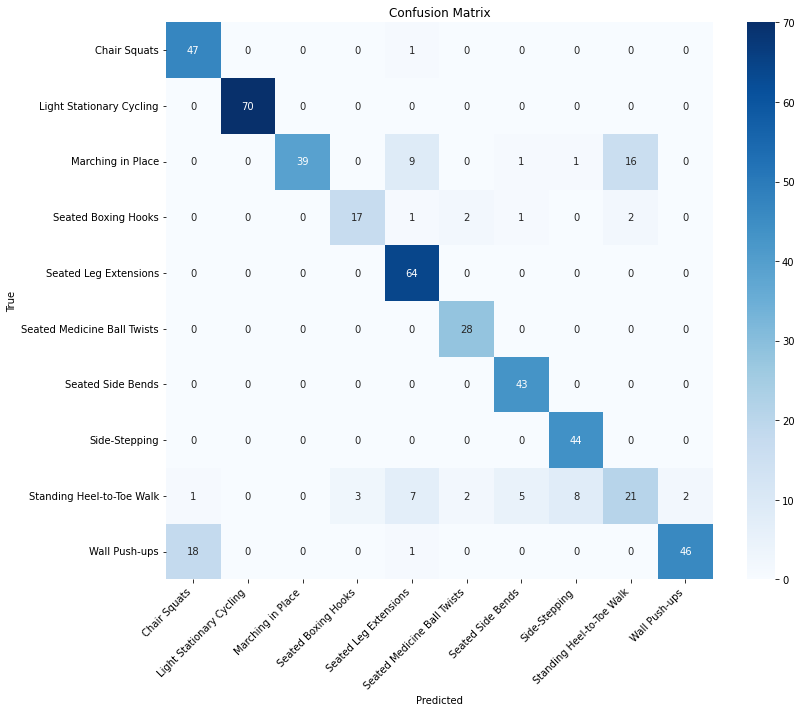

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_names, yticklabels=activity_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('MobileHART_confusion_matrix.png')
plt.show()

# Plot Learning Curves

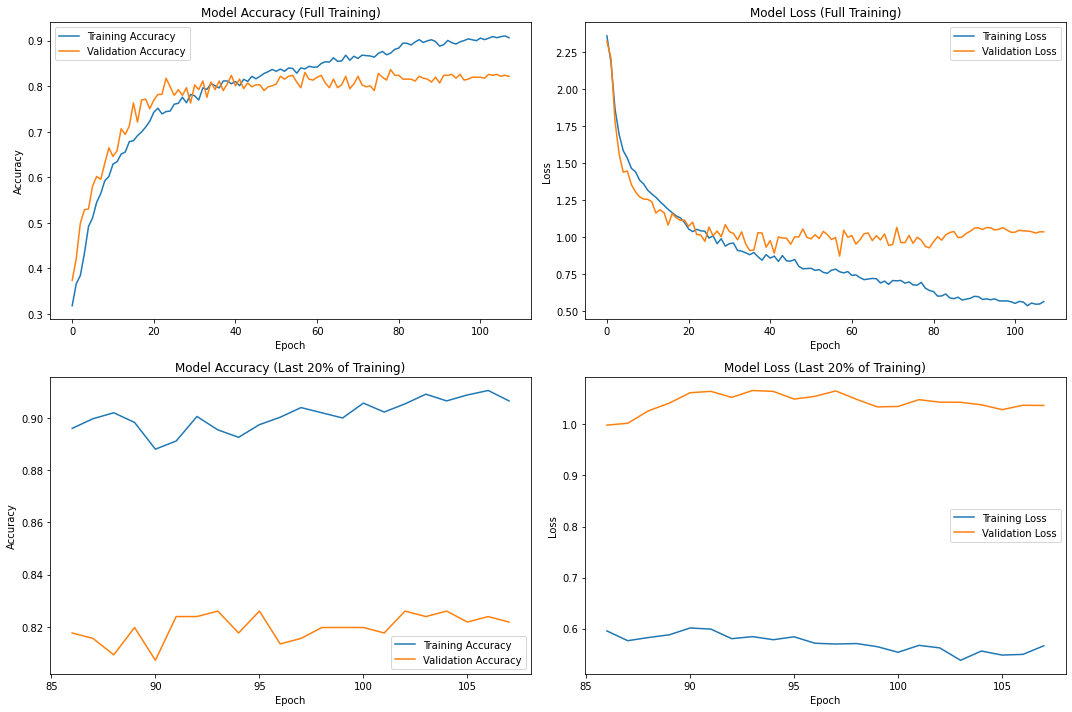

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Full Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Full Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

train_length = len(history.history['accuracy'])
start_idx = int(train_length * 0.8)

plt.subplot(2, 2, 3)
plt.plot(range(start_idx, train_length), history.history['accuracy'][start_idx:], label='Training Accuracy')
plt.plot(range(start_idx, train_length), history.history['val_accuracy'][start_idx:], label='Validation Accuracy')
plt.title('Model Accuracy (Last 20% of Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(start_idx, train_length), history.history['loss'][start_idx:], label='Training Loss')
plt.plot(range(start_idx, train_length), history.history['val_loss'][start_idx:], label='Validation Loss')
plt.title('Model Loss (Last 20% of Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('MobileHART_training_history_500_epochs.png')
plt.show()

# Activity-specific Performance Analysis

In [18]:
activity_performance = {}

for i, activity_name in enumerate(activity_names):
    activity_indices = (y_test == i)
    if np.sum(activity_indices) > 0:
        activity_X = X_test[activity_indices]
        activity_y = y_test[activity_indices]
        
        activity_pred_prob = best_model.predict(activity_X)
        activity_pred = np.argmax(activity_pred_prob, axis=1)
        
        activity_accuracy = np.mean(activity_pred == activity_y)
        activity_performance[activity_name] = {
            'accuracy': activity_accuracy,
            'support': np.sum(activity_indices)
        }

print("\nActivity-wise Performance:")
for activity, metrics in activity_performance.items():
    print(f"{activity:30} Accuracy: {metrics['accuracy']*100:6.2f}%  Support: {metrics['support']}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

Activity-wise Performance:
Chair Squats                   Accuracy:  97.92%  Support: 48
Light Stationary Cycling       Accuracy: 100.00%  Support: 70
Marching in Place              Accuracy:  59.09%  Support: 66
Seated Boxing Hooks            Accuracy:  73.91%  Support: 23
Seated Leg Extensions          Accuracy: 100.00%  Support: 64
Seated Medicine Ball Twists    Accuracy: 100.00%  Support: 28
Seated Side Bends              Accuracy: 100.00%  Support: 43
Side-Stepping                  Accuracy: 100.00%  Support: 44
Standing Heel-to-Toe Walk      Accuracy:  42.86%  Support: 49
Wall Push-ups              

# Save Training History

In [19]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('MobileHART_training_history_500_epochs.csv')
print("\nTraining history saved to 'MobileHART_training_history_500_epochs.csv'")


Training history saved to 'MobileHART_training_history_500_epochs.csv'
